## Construction of custom coadd using the visits with mean PSF size <= given value

In [19]:
import time
import getpass
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats

from pandas.testing import assert_frame_equal
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.time import Time

# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query

# Rubin TAP service utilities
import lsst.geom as geom
import lsst.afw.display as afwDisplay  # for image visualization
import lsst.afw.table as afwTable
from lsst.daf.butler import Butler, DatasetType, CollectionType # access to LSST data products
import lsst.daf.base as dafBase
afwDisplay.setDefaultBackend('matplotlib')
from lsst.afw.geom.ellipses import Quadrupole, SeparableDistortionTraceRadius
from lsst.afw.cameraGeom import utils as cgUtils
from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms
from lsst.obs.lsst.cameraTransforms import ampPixelToCcdPixel
from lsst.afw.cameraGeom import FIELD_ANGLE, FOCAL_PLANE, PIXELS
import lsst.afw.cameraGeom as cameraGeom
import lsst.afw.geom as afwGeom
# lsst packages for executing pipeline tasks
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline, Instrument


# To ignore some kinds of warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
repo = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler(repo, collections=collection)


In [8]:
def fullVisit_RADEC_Only_catalog(visit,n_ccds):
    ra, dec, psf_size, psf_ellipticity = [],[],[],[]
    
    for det in range(n_ccds):
        dataId = {'visit':visit,'detector': det} 
        #ccd = butler.get('calexp', **dataId)
        src = butler.get('src', **dataId)
        #point_sources = src[src['calib_psf_used'] == True]
        point_sources = src[src['base_ClassificationExtendedness_value'] == 0]
    
        for i in range(len(point_sources)):
            ra.append(point_sources[i]['coord_ra'])
            dec.append(point_sources[i]['coord_dec'])
            psf_size.append(np.sqrt((point_sources[i]['base_SdssShape_psf_xx'] + point_sources[i]['base_SdssShape_psf_yy']) / 2.))
            i_xx = point_sources[i]['base_SdssShape_psf_xx']
            i_yy = point_sources[i]['base_SdssShape_psf_yy']
            i_xy = point_sources[i]['base_SdssShape_psf_xy']
            e1 = (i_xx - i_yy) / (i_xx + i_yy)
            e2 = (2. * i_xy) / (i_xx + i_yy)
            psf_ellipticity.append(np.sqrt(e1**2 + e2**2))
         
    return np.asarray(ra), np.asarray(dec), np.asarray(psf_size), np.asarray(psf_ellipticity) 


In [9]:
my_ra_deg = 55.745834
my_dec_deg = -32.269167
radius = 0.5

ccdTableRef = list(butler.registry.queryDatasets('ccdVisitTable'))
ccdTable = butler.get(ccdTableRef[0])
posRA = (ccdTable['ra'] <= my_ra_deg + radius ) & (ccdTable['ra'] >= my_ra_deg - radius )
posDEC = (ccdTable['decl'] <= my_dec_deg + radius ) & (ccdTable['decl'] >= my_dec_deg - radius )

ccd_visit_list = ccdTable[posRA & posDEC][['visitId', 'detector', 'band']]

In [10]:
visitTableRef = list(butler.registry.queryDatasets('visitTable'))
visitTable = butler.get(visitTableRef[0])
visitTable.columns

Index(['visit', 'physical_filter', 'band', 'ra', 'decl', 'skyRotation',
       'azimuth', 'altitude', 'zenithDistance', 'airmass', 'expTime',
       'expMidpt', 'expMidptMJD', 'obsStart', 'obsStartMJD'],
      dtype='object')

In [11]:
for i in "ugriyz":
    print("unique visits " + i, len(ccd_visit_list[ccd_visit_list['band'] == i]['visitId'].unique()))

unique visits u 64
unique visits g 81
unique visits r 200
unique visits i 197
unique visits y 125
unique visits z 107


In [12]:
visits_g = ccd_visit_list[ccd_visit_list['band'] == 'g']['visitId'].unique()

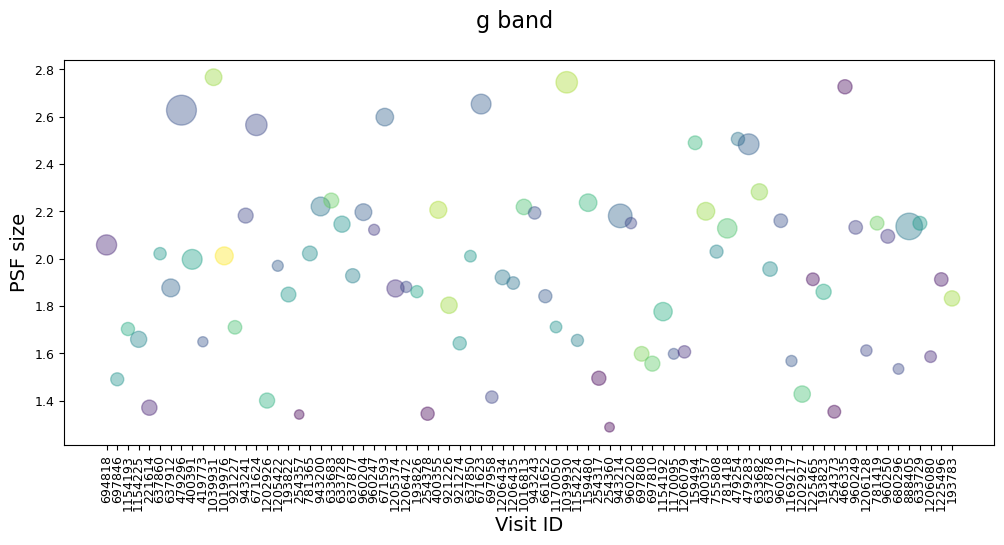

In [13]:
dataset = {}
n_visits = len(visits_g)
xticklabels =[]
metrics = np.empty((0,7), float)

for i,v in enumerate(visits_g[0:n_visits]):
    try:
        dataId = {'visit':v,'detector': 0} 
        ra, dec, psf_size, psf_e = fullVisit_RADEC_Only_catalog(v,4)
        xticklabels.append(v)
        mean_PSFs = np.mean(psf_size)
        median_PSFs = np.median(psf_size)
        std_PSFs = np.std(psf_size)
        range_PSFs = np.max(psf_size) - np.min(psf_size)
        IQR_PSFs = stats.iqr(psf_size)
        #metrics: visit_id, mean_PSFs, median_PSFs, std_PSFs, range_PSFs, IQR_PSFs 
        airmass = visitTable['airmass'][visitTable['visit'] == v]
        metrics = np.append(metrics, np.array([[v,mean_PSFs, median_PSFs, std_PSFs, range_PSFs, IQR_PSFs, airmass]]), axis=0)

    except:
        pass

df_metrics = pd.DataFrame(data= metrics, columns = ['visit_id', 'mean_PSFs', 'median_PSFs', 'std_PSFs', 'range_PSFs', 'IQR_PSFs', 'airmass'])
df_metrics['visit_id'] = df_metrics['visit_id'].astype('int')
df_metrics['std_PSFs'] = df_metrics['std_PSFs'].astype('float')

fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(range(len(df_metrics)), df_metrics['mean_PSFs'], s = df_metrics['std_PSFs']*20000, c = df_metrics['airmass'], cmap = 'viridis', alpha=0.4)
ax.set_xticks(range(len(df_metrics)))
ax.tick_params(axis='both', which='major', labelsize=9)
ax.set_xticklabels(xticklabels, rotation = 90)
ax.set_xlabel('Visit ID', fontsize=14)
ax.set_ylabel('PSF size', fontsize=14);
fig.suptitle("g band", fontsize=16);

### Select the visits to construct the coadd

In [14]:
## TO DO: select the visits used for a single patch
visits_selected = df_metrics['visit_id'][df_metrics['mean_PSFs'] <= 2.0]

In [16]:
my_visits_tupleString = "("+",".join(visits_selected.astype(str))+")"
print(my_visits_tupleString)

(697846,1154193,1154225,221614,637912,400391,419773,921227,1202926,1205422,193822,254357,637877,1205374,1206472,193826,254378,921226,921274,697958,1206434,1206435,661652,1170050,1154224,254317,254360,697808,697810,1154192,1170095,1206079,637878,1169217,1202927,1225465,193823,254373,1206128,680296,1206080,1225496,193783)


In [17]:
## list all the collections under 'kalamo'
#!butler query-collections dp02 --chains=tree u/kalamo/*

In [20]:
my_username = getpass.getuser()
my_outputCollection = 'u/'+my_username+'/custom_coadd_test1'
#print('Name of new butler collection for my output: ', my_outputCollection)

In [21]:
del butler

'kalamo'

In [23]:
# current version of lsst pipelines
# the following procedure only works with w_2022_40
! echo $IMAGE_DESCRIPTION

Recommended (Weekly 2023_21)


> **from MELISSA GRAHAM notebook :** In future updates to the LSST Science Pipelines, it will be possible to use: <br>
>`simpleButler = SimplePipelineExecutor.prep_butler(config, inputs=[collection], output=my_outputCollection)`

>For the LSST Science Pipelines version Weekly_2022_22, the following workaround is needed to set up a simple butler and create a new output collection with the name selected above.

In [ ]:
# set up the butler for the new collection

simpleButler = SimplePipelineExecutor.prep_butler('dp02', 
                                                  inputs=['2.2i/runs/DP0.2'], 
                                                  output=my_outputCollection)

'''
outputRun = f"{my_outputCollection}/visits_PSFsize_lt2"

tmpButler = Butler(config, writeable=True)

tmpButler.registry.registerCollection(outputRun, CollectionType.RUN)
print('Made CollectionType.RUN: ', outputRun)

tmpButler.registry.registerCollection(my_outputCollection, CollectionType.CHAINED)
print('Made CollectionType.CHAINED: ', my_outputCollection)

collections = [collection]
collections.insert(0, outputRun)

tmpButler.registry.setCollectionChain(my_outputCollection, collections)

simpleButler = Butler(butler=tmpButler, collections=[my_outputCollection], run=outputRun)

del tmpButler
'''

In [ ]:
## selection of makeWarp and assembleCoadd tasks
assembleCoaddPipeline = Pipeline.from_uri('${PIPE_TASKS_DIR}/pipelines/DRP.yaml#makeWarp,assembleCoadd')

> **from MELISSA GRAHAM notebook :** There is only one configuration that must be set, and it is to clarify to the pipeline that it _does not_ need to redo a final image characterization step.
Currently, this configuration is needed due to a version mismatch: the DP0.2 data sets were processed with Version 23 of the LSST Science Pipelines, whereas this notebook uses the version "Weekly 2022_22".
This configuration might not be needed in the future.

In [ ]:
assembleCoaddPipeline.addConfigOverride('makeWarp', 'doApplyFinalizedPsf', False)

In [ ]:
queryString = f"tract = {my_tract} AND patch = {my_patch} AND " + \
              f"visit in {my_visits_tupleString} AND skymap = 'DC2'"

print(queryString)

In [ ]:
## RUN the pipeline

%%time
spe = SimplePipelineExecutor.from_pipeline(assembleCoaddPipeline, where=queryString, butler=simpleButler)

In [ ]:
%%time
quanta = spe.run()

In [ ]:
config1 = 'dp02'
collection1 = '2.2i/runs/DP0.2'
butler1 = Butler(config1, collections=collection1)
my_dataId1 = {'band': 'i', 'tract': 4431, 'patch': 17}

config2 = "dp02"
collection2 = "u/kalamo/custom_coadd_test1/visits_PSFsize_lt2"
butler2 = Butler(config2, collections=collection2)
my_dataId2 = {'band': 'i', 'tract': 4431, 'patch': 17}

allVisits_deepCoadd = butler1.get('deepCoadd', dataId=my_dataId1)
bestAirmass_deepCoadd = butler2.get('deepCoadd', dataId=my_dataId2)


fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plt.sca(ax[0])  
display1 = afwDisplay.Display(frame=fig) 
display1.scale('asinh', min=-0.3, max=0.5)
#display1.scale('asinh', 'zscale')
display1.mtv(allVisits_deepCoadd.image)
display1.show_colorbar(False)
ax[0].axis('off')

plt.sca(ax[1])
display2 = afwDisplay.Display(frame=fig)
display2.scale('asinh', min=-0.3, max=0.5)
display2.mtv(bestAirmass_deepCoadd.image)
display2.show_colorbar(False)
ax[1].axis('off')
plt.tight_layout()
plt.show()
